In [23]:
from networks_bf import get_all_devices_combined
from services_bf import get_all_services
import itertools
import numpy as np
import pandas as pd

In [24]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def preprocess_data(R, S, X, PI, PM, SAL, SIPS, SL):
    # Initialize the scalers
    scaler = MinMaxScaler()
    one_hot_encoder = OneHotEncoder()

    # Normalize the multi-dimensional arrays
    R_norm = scaler.fit_transform(R.flatten().reshape(-1, 1)).reshape(R.shape)
    S_norm = scaler.fit_transform(S.flatten().reshape(-1, 1)).reshape(S.shape)
    X_norm = scaler.fit_transform(X.flatten().reshape(-1, 1)).reshape(X.shape)
    PI_norm = scaler.fit_transform(PI.flatten().reshape(-1, 1)).reshape(PI.shape)
    PM_norm = scaler.fit_transform(PM.flatten().reshape(-1, 1)).reshape(PM.shape)

    # Normalize the one-dimensional arrays
    SAL_norm = scaler.fit_transform(np.array(SAL).reshape(-1, 1)).flatten()
    SIPS_norm = scaler.fit_transform(np.array(SIPS).reshape(-1, 1)).flatten()

    # One-hot encode the categorical array SL
    SL_encoded = one_hot_encoder.fit_transform(np.array(SL).reshape(-1, 1)).toarray()

    # Flatten the arrays and concatenate
    flattened_data = np.concatenate((R_norm.flatten(), S_norm.flatten(), X_norm.flatten(),
                                     PI_norm.flatten(), PM_norm.flatten(), SAL_norm, 
                                     SIPS_norm, SL_encoded.flatten()))

    return flattened_data

In [80]:
# Get the real output values
file_path = 'results_mini_bf.csv'
bf_data = pd.read_csv(file_path)

bf_data['placement_physical'] = bf_data['placement_physical'].apply(lambda x: eval(x))
bf_data['placement_vm'] = bf_data['placement_vm'].apply(lambda x: eval(x))

pms = bf_data['placement_physical']
vms = bf_data['placement_vm']

merged = [np.concatenate((pm, vm)) for pm, vm in zip(pms, vms)]

max_output_size = max(len(array) for array in merged)  # Find the size of the largest array
padded_outputs = [np.pad(array, (0, max_output_size - len(array)), mode='constant', constant_values=-1) for array in merged]

outputs_array = np.array(padded_outputs)

In [82]:
inputs = []
for c in range(1, 101):
    
    print(f"Processing config-{c}....")
    
    physical_machines = get_all_devices_combined(f"config-{c}")
    services = get_all_services(f"config-{c}")
    
    # Define the problem-specific parameters
    n = len(physical_machines)  # Number of physical machines
    s = len(services)  # Number of services
    
    vm_list = []
    
    for p in range(len(physical_machines)):
        for v in range(len(physical_machines[p].guest_machines)):
            vm_list.append([p, v])
    
    # Calculate all permutations of vm_list with s places (with repetition)
    permutations = itertools.product(vm_list, repeat=s)
    
    # Variable number of virtual machines for each physical machine
    max_v = max(map(lambda machine: len(machine.guest_machines), physical_machines))
    
    ################ Physical and virtual machine configurations ##################
    
    # Initialization
    R = np.empty(shape=(n, max_v))  # Request network delay of the machine
    R.fill(999999) # Initialize with very large value
    S = np.empty(shape=(n, max_v))  # Response network delay of the machine
    S.fill(999999) # Initialize with very large value
    X = np.empty(shape=(n, max_v))  # Maximum IPS possible
    X.fill(1) # Initialize with 1
    
    PI = np.empty(shape=(n, max_v))  # Power consumption in idle
    PI.fill(999) # Initialize with very large value
    PM = np.empty(shape=(n, max_v))  # Maximum power consumption
    PM.fill(999) # Initialize with very large value
    
    # Fill in with the actual numbers
    for i in range(len(physical_machines)):
        for j in range(len(physical_machines[i].guest_machines)):
            R[i][j] = physical_machines[i].guest_machines[j].net_delay_request
            S[i][j] = physical_machines[i].guest_machines[j].net_delay_response
            X[i][j] = physical_machines[i].guest_machines[j].max_instructions_per_second
            PI[i][j] = physical_machines[i].guest_machines[j].idle_cpu_utilization
            PM[i][j] = physical_machines[i].guest_machines[j].max_cpu_utilization
    
    ################ Service configurations ###################
    
    # Acceptable latencies for services
    SAL = [service.acceptable_latency for service in services]
    # Initialize IPS values for services (replace with actual data)
    SIPS = [service.average_instructions_per_second for service in services]
    # Layers considered for service
    SL = [service.layer for service in services]
    
    ################# Preprocess the data ####################
    input_data = preprocess_data(R, S, X, PI, PM, SAL, SIPS, SL)
    inputs.append(input_data)

Processing config-1....
Processing config-2....
Processing config-3....
Processing config-4....
Processing config-5....
Processing config-6....
Processing config-7....
Processing config-8....
Processing config-9....
Processing config-10....
Processing config-11....
Processing config-12....
Processing config-13....
Processing config-14....
Processing config-15....
Processing config-16....
Processing config-17....
Processing config-18....
Processing config-19....
Processing config-20....
Processing config-21....
Processing config-22....
Processing config-23....
Processing config-24....
Processing config-25....
Processing config-26....
Processing config-27....
Processing config-28....
Processing config-29....
Processing config-30....
Processing config-31....
Processing config-32....
Processing config-33....
Processing config-34....
Processing config-35....
Processing config-36....
Processing config-37....
Processing config-38....
Processing config-39....
Processing config-40....
Processin

In [83]:
max_input_size = max(len(array) for array in inputs)  # Find the size of the largest array
padded_inputs = [np.pad(array, (0, max_input_size - len(array)), mode='constant', constant_values=-1) for array in inputs]

inputs_array = np.array(padded_inputs)

Epoch 1/200
10/10 [==============================] - 0s 9ms/step - loss: 0.6314 - acc: 0.0250 - val_loss: 0.5224 - val_acc: 0.0500
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6306 - acc: 0.0125 - val_loss: 0.5171 - val_acc: 0.0500
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 0.6091 - acc: 0.0375 - val_loss: 0.5130 - val_acc: 0.0000e+00
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 0.5908 - acc: 0.0375 - val_loss: 0.5090 - val_acc: 0.0000e+00
Epoch 5/200
10/10 [==============================] - 0s 2ms/step - loss: 0.5879 - acc: 0.0250 - val_loss: 0.5051 - val_acc: 0.0000e+00
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 0.5777 - acc: 0.0375 - val_loss: 0.5013 - val_acc: 0.1000
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 0.5651 - acc: 0.0375 - val_loss: 0.4980 - val_acc: 0.2000
Epoch 8/200
10/10 [==============================] - 0s 2ms/step - loss

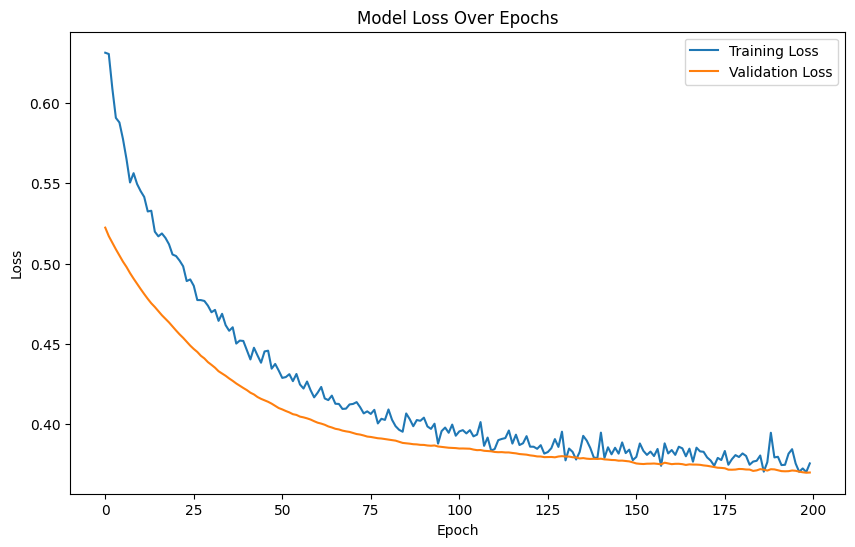

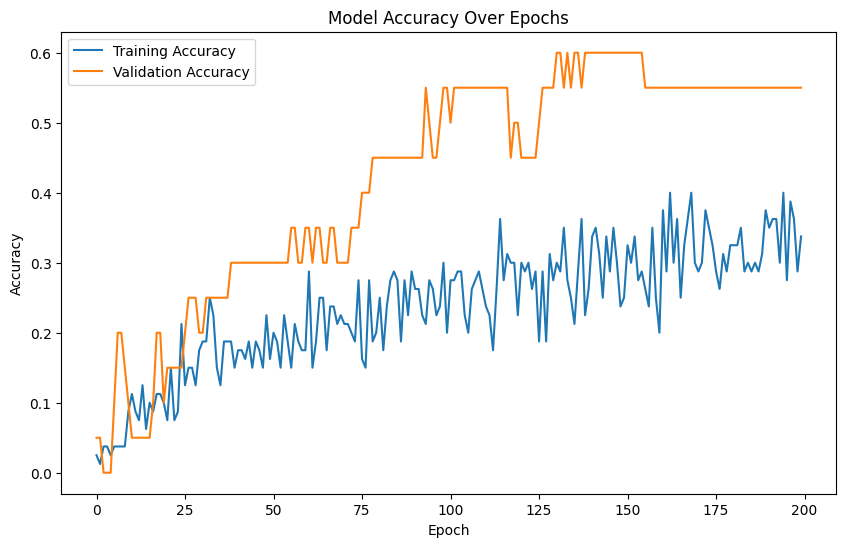

1/1 [==============================] - 0s 10ms/step - loss: 0.3700 - acc: 0.5500


[0.369968980550766, 0.550000011920929]

In [172]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Define the learning rate variable
learning_rate = tf.Variable(0.001, trainable=False)

# For example, set a new learning rate of 0.0001
keras.backend.set_value(learning_rate, 0.0001)

# Split the data into training and test sets (e.g., 80% training, 20% test)
train_ratio = 0.8
train_size = int(len(inputs_array) * train_ratio)
X_train, X_test = inputs_array[:train_size], inputs_array[train_size:]
y_train, y_test = outputs_array[:train_size], outputs_array[train_size:]

# Custom loss function
def custom_loss(y_true, y_pred):
    def calculate_loss(yt, yp):
        yt_rounded = tf.cast(tf.round(yt), tf.int32)
        yp_rounded = tf.cast(tf.round(yp), tf.int32)

        length = tf.size(yt_rounded) // 2
        indices = tf.where(tf.equal(yt_rounded, -1))
        if tf.shape(indices)[0] > 0:
            length = tf.cast(indices[0][0] // 2, tf.int32)

        actual_pms = yt_rounded[:length]
        actual_vms = yt_rounded[length:length*2]
        predicted_pms = yp_rounded[:length]
        predicted_vms = yp_rounded[length:length*2]

        # Check if PMs match and then check VMs
        pm_matches = tf.equal(actual_pms, predicted_pms)
        vm_matches = tf.equal(actual_vms, predicted_vms)
        correct_predictions = tf.cast(pm_matches, tf.float32) + tf.cast(tf.logical_and(pm_matches, vm_matches), tf.float32)

        return (2 * tf.cast(length, tf.float32) - tf.reduce_sum(correct_predictions)) / (2 * tf.cast(length, tf.float32))

    # Compute the loss for each element in the batch and return the mean loss
    batch_loss = tf.map_fn(lambda x: calculate_loss(x[0], x[1]), (y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(batch_loss)      

# Custom accuracy metric
def custom_accuracy(y_true, y_pred):
    def calculate_accuracy(yt, yp):
        yt_rounded = tf.cast(tf.round(yt), tf.int32)
        yp_rounded = tf.cast(tf.round(yp), tf.int32)

        length = tf.size(yt_rounded) // 2
        indices = tf.where(tf.equal(yt_rounded, -1))
        if tf.shape(indices)[0] > 0:
            length = tf.cast(indices[0][0] // 2, tf.int32)

        actual_pms = yt_rounded[:length]
        actual_vms = yt_rounded[length:length*2]
        predicted_pms = yp_rounded[:length]
        predicted_vms = yp_rounded[length:length*2]

        # Check if PMs match and then check VMs
        pm_matches = tf.equal(actual_pms, predicted_pms)
        vm_matches = tf.equal(actual_vms, predicted_vms)
        correct_predictions = tf.cast(pm_matches, tf.float32) + tf.cast(tf.logical_and(pm_matches, vm_matches), tf.float32)

        return tf.reduce_sum(correct_predictions) / (2 * tf.cast(length, tf.float32))

    # Compute the accuracy for each element in the batch and return the mean accuracy
    batch_accuracy = tf.map_fn(lambda x: calculate_accuracy(x[0], x[1]), (y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(batch_accuracy)     


# Define the neural network model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))  # Output layer with a number of neurons equal to the output size

# model.compile(optimizer='sgd', loss=custom_loss, metrics=[custom_accuracy])
model.compile(optimizer='sgd', loss='mse', metrics=['acc'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test))

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
# plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model's performance
model.evaluate(X_test, y_test)